In [30]:
import types
import pickle

import torch
from torch.nn.functional import leaky_relu
from torch_geometric.utils import softmax
import matplotlib.pyplot as plt

from dataset import get_dataset
from model import Model

In [46]:
EXP_DIR = 'results/smoothing/2024-06-30-01-51-01'
CKPT = 300

with open(f'{EXP_DIR}/config.pkl', 'rb') as f:
    config = pickle.load(f)

DEVICE = torch.device(f'cuda:{config.device_index}' if torch.cuda.is_available() and config.device_index is not None else 'cpu')
dataset = get_dataset(config.dataset, config.task, DEVICE)
state_dict = torch.load(f'{EXP_DIR}/ckpt-{CKPT}.pt')

In [68]:
model = Model(config).to(DEVICE)
model.load_state_dict(state_dict)

attention_scores = list()

def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        
    alpha = alpha_j + alpha_i
    alpha = leaky_relu(alpha, self.negative_slope)
    alpha = softmax(alpha, index, ptr, size_i)

    attention_scores.append(alpha)
    
    x_j = alpha.unsqueeze(-1) * x_j
    x_j = self.drop_strategy.apply_message_mat(x_j, self.training)

    return x_j

for mp_layer in model.message_passing:
    mp_layer.message = types.MethodType(message, mp_layer)

dataset.eval(model)
attention_scores = torch.stack([attention_score.mean(dim=1) for attention_score in attention_scores])

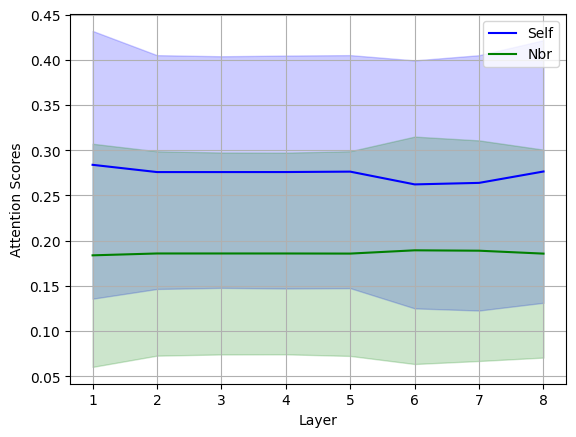

In [70]:
std, mean = torch.std_mean(attention_scores[:, dataset.edge_index.size(1):], dim=1)
plt.plot(range(1, len(mean)+1), mean, color='blue', label='Self')
plt.fill_between(range(1, len(mean)+1), mean-std, mean+std, alpha=0.2, color='blue')

std, mean = torch.std_mean(attention_scores[:, :dataset.edge_index.size(1)], dim=1)
plt.plot(range(1, len(mean)+1), mean, color='green', label='Nbr')
plt.fill_between(range(1, len(mean)+1), mean-std, mean+std, alpha=0.2, color='green')

plt.xlabel('Layer')
plt.ylabel('Attention Scores')
plt.grid()
plt.legend()
plt.show()